In [1]:
import numpy as np
from collections import Counter
import pandas as pd
from pathlib import Path
from scipy.spatial import distance 
from scipy.stats import pearsonr, linregress
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_palette('colorblind')

## Parse annotations

Create a dictionary with pvog id as key and a list of the words that appear in its annotations strings.

In [3]:
annotations_dic = {}
with open('../../data/pvogs/VOGTable.txt', 'r') as fin:
    for line in fin:
        fields = [f.strip() for f in line.split('\t')]
        pvog = fields[0]
        annotations_list = [ann.strip() for ann in fields[6].split(';')]
        words = []
        for ann in annotations_list:
            if ann == '':
                pass
            else:
                some_words = [w.strip('[](),/').lower() for w in ann.split(' ')[:-1]]
                words.extend(some_words)
        annotations_dic[pvog] = words

In [4]:
words_blacklist = [
    'hypothetical',
    'hypotheical', 
    'hypothetical-acquired', 
    'hypotthetical', 
    'hypothethical', 
    'hyphothetical', 
    'hypothetical-protein',
    'hypho'
    'predicted',
    'protein', 
    'unknown', 
    'putative', 
    'phage', 
    'bacteriophage',
    'no', 
    'annotation', 
    'provided',
    'gene',
    'and',
    'in',
    'conserved',
    '',
    '#',
    '&',
]

In [5]:
corpus = []
for word_list in annotations_dic.values():
    for w in word_list:
        if w not in words_blacklist:
            corpus.append(w)

In [6]:
# print(sorted(set(sorted(corpus))))
corpus_unique = set(corpus)

In [7]:
good_pvogs = []
counter = 0
for pvog in annotations_dic:
    words = annotations_dic[pvog]
    good_words = []
    for word in words:
        if word in corpus_unique:
            good_words.append(word)
    if len(good_words) == 0:
        counter +=1
    else: 
        good_pvogs.append(pvog)

In [8]:
counter

4245

In [9]:
good_annotations = {}
for pvog in good_pvogs:
    annotations = annotations_dic[pvog]
    good_words = []
    for word in annotations:
        if word in corpus:
            good_words.append(word)
    good_annotations[pvog] = good_words

In [10]:
corpus_size = len(corpus)

In [11]:
print(corpus_size)

56249


In [12]:
corpus_counts = Counter(corpus)

In [13]:
word_weights = {k: np.float64(v / corpus_size) for k,v in corpus_counts.items()}

In [14]:
FEATURES = ['jaccard_score', 'same_score', 
            'inwards_score', 'outwards_score', 
            'avg_distance', 'mean_ani', 
            'mean_aai'
           ]
FEAT_LAB = FEATURES.copy()
FEAT_LAB.append('label')
SCALE_DATA = True

In [15]:
def read_scores_table(scores_fp, label=None):
    """
    Read a table from a tsv file provided as a path.
    Return a dataframe.
    
    If label is set, append a column named `label` with
    the provided value
    """
    scores_df = pd.read_csv(scores_fp, sep='\t')
    scores_df['interaction'] = scores_df['pvog1'] + '-' + scores_df['pvog2']
    # Unpack features list because I want interaction prepended.
    scores_df = scores_df[['interaction', *FEATURES]]    
    if label is not None:
        scores_df['label'] = label
    return scores_df


def concat_data_frames(pos_df, 
                       neg_df, 
                       subsample=False,
                       clean=True,
                       is_scaled=True,
                      ):
    """
    Concatenate two dataframes.
    
    subsample:bool 
        Subsample the `neg_df` to a number of
        observations equal to the number of pos_df 
        (balance datasets)
    
    clean:bool
        Remove observations with a value of `avg_distance` == 100000 or 1.
    
    is_scaled:bool
        The features have been scaled to a range 0-1
    
    Return:
    concat_df: pd.DataFrame
        The concatenated data frame
    """
    
    if clean is True:
        pos_df = remove_ambiguous(pos_df)
        neg_df = remove_ambiguous(neg_df)
    
    n_positives = pos_df.shape[0]
    n_negatives = neg_df.shape[0]
    
    # Remove possible duplicate interactions from the negatives
    # This might happen because of the random selection when creating the set
    # Why I also select more negatives to begin with
    neg_df = neg_df.loc[~neg_df['interaction'].isin(pos_df['interaction'])]
    
    if (n_positives != n_negatives) and (subsample is True):
        neg_df = neg_df.sample(n=n_positives, random_state=1)
    concat_df = pd.concat([pos_df, neg_df])
    
    assert concat_df[concat_df.duplicated(subset=['interaction'])].empty == True, concat_df.loc[concat_df.duplicated(subset=['interaction'], keep=False)]
    
    return concat_df

def scale_df(input_df):
    """
    Scale all feature values in the data frame to [0-1].
    """
    maxes = input_df[FEATURES].max(axis=0)
    scaled_data = input_df[FEATURES].divide(maxes)
    if 'label' in input_df.columns:
        scaled_df = pd.concat([input_df['interaction'], scaled_data, input_df['label']], axis=1)
    else:
        scaled_df = pd.concat([input_df['interaction'], scaled_data], axis=1)
    return scaled_df

def remove_ambiguous(input_df):
    """
    Select observations in the `input_df` that have feature values
    """
    df_clean = input_df[(input_df.jaccard_score != 0)] # This is true if they don't co-occur
    return df_clean


In [16]:
def calculate_cosine_distance(interaction_string,
                              annotations_dic,
                              informative_pvogs,
                              min_terms = 1, 
                              words_weights = None
                             ):
    # Get VOG id
    interactors = interaction_string.split('-')
    pvog_1 = interactors[0]
    pvog_2 = interactors[1]
    if (pvog_1 in informative_pvogs) and (pvog_2 in informative_pvogs):
    
        # Grab the annotations for each pvog
        terms_pvog_1 = annotations_dic[pvog_1]
        terms_pvog_2 = annotations_dic[pvog_2]
        if len(terms_pvog_1) >= min_terms and \
        len(terms_pvog_2) >= min_terms:
    
            # Count number of occurrences for each word
            terms_counter_1 = Counter(terms_pvog_1)
            terms_counter_2 = Counter(terms_pvog_2)
    
            # Get the set of all terms
            all_unique_terms = sorted(set(terms_counter_1.keys()).
                              union(set(terms_counter_2.keys()))
                             )
            terms_freq_1 = []
            terms_freq_2 = []
            weights = []
            for term in all_unique_terms:
                term_freq_1 = terms_counter_1.get(term, 0)
                terms_freq_1.append(term_freq_1)

                term_freq_2 = terms_counter_2.get(term, 0)
                terms_freq_2.append(term_freq_2)
                if words_weights is not None:
                    weights.append(1- words_weights[term])

            if words_weights is not None:
                cos_distance = distance.cosine(terms_freq_1, terms_freq_2, weights)
            else:
                cos_distance = distance.cosine(terms_freq_1, terms_freq_2)
        else:
            cos_distance = np.nan
    else:
        cos_distance=np.nan
        
    return cos_distance

In [17]:
pos_df = read_scores_table('../../results/interaction_datasets/positives/positives.features.tsv', 
                           label=1)

In [18]:
neg_df = read_scores_table('../../results/interaction_datasets/N8/N8.features.tsv', 
                           label=0)

In [19]:
if SCALE_DATA is True:
    pos_df = scale_df(pos_df)
    neg_df = scale_df(neg_df)
    
posneg = concat_data_frames(pos_df, neg_df,
                           clean=True,
                           subsample=True,
                           is_scaled=SCALE_DATA)

In [20]:
posneg['cosine_dist'] = posneg.interaction.apply(calculate_cosine_distance,
                                            args=(good_annotations, good_pvogs, 1, word_weights)
                                            )

In [21]:
posneg = posneg.dropna()

In [22]:
figures_dir = Path("../../results/figures")
figures_dir.mkdir(exist_ok=True)

Text(16.424999999999997, 0.5, 'Density')

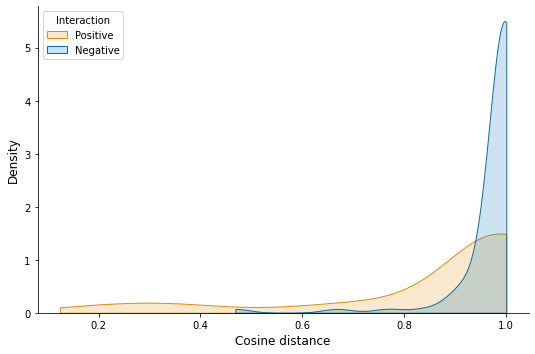

In [23]:
displot = sns.displot(
    posneg, 
    x='cosine_dist', 
    hue='label',
    kind='kde',
    fill = True,
    legend=False,
    cut = 0,
    alpha=0.2,
    height=5,
    aspect=1.5,
)
plt.legend(title="Interaction", loc='upper left', labels = ['Positive', 'Negative'])
plt.xlabel("Cosine distance", fontsize=12)
plt.ylabel('Density', fontsize=12)

# plt.axvline(x=0.5)
# for t, l in zip(a._legend.texts, ("Negatives", "Positives")):
#     t.set_text(l)


In [24]:
posneg.shape[0]

183

In [34]:
def save_it(fig, output_path, suffix = None, 
            formats = ['pdf', 'svg', 'png', 'eps'],
           dpi = 600):
    
    
    for fmt in formats:
        figout_base = 'fig_{}.{}'.format(suffix, fmt)
        figout_fp = output_path / Path(figout_base)
        fig.savefig(
            figout_fp, 
            dpi=dpi, 
            format=fmt,
            bbox_inches='tight'
        )

In [26]:
save_it(displot.fig, figures_dir, 7)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [27]:
def assign_proba_to_bin(proba):
    
    proba = np.float64(proba)
    
    if proba == 0.:
        binn = 0.
    elif 0. <= proba < 0.1:
        binn = 0.1
    elif 0.1 <= proba < 0.2:
        binn = 0.2
    elif 0.2 <= proba < 0.3:
        binn= 0.2
    elif 0.3 <= proba < 0.4:
        binn = 0.3
    elif 0.4 <= proba < 0.5:
        binn = 0.4
    elif 0.5 <= proba < 0.6:
        binn = 0.5
    elif 0.6 <= proba < 0.7:
        binn = 0.6
    elif 0.7 <= proba < 0.8:
        binn = 0.7
    elif 0.8 <= proba < 0.9:
        binn = 0.8
    elif 0.9 <= proba < 0.99:
        binn = 0.9
    else:
        binn = 1.
    return binn

In [52]:
final_data = {
    'interaction': [],
    'label': [],
    'proba': [],
    'cosine_dist': [],
    'bin': [],    
}

counter = 0

with open('../../results/predictions_annotations_features.tsv', 'r') as fin:
    next(fin)
    for line in fin:
        fields = [f.strip() for f in line.split('\t')]
        
        interaction_string = fields[0]
        final_data['interaction'].append(interaction_string)
        
        label = fields[1]
        final_data['label'].append(label)
        
        proba = np.float64(fields[2])
        final_data['proba'].append(proba)
        
        binn = assign_proba_to_bin(proba)
        final_data['bin'].append(binn)
        
        cosine_dist = calculate_cosine_distance(interaction_string, 
                                                good_annotations, 
                                                good_pvogs, 
                                                10, 
                                                word_weights
                                               )
            
        final_data['cosine_dist'].append(cosine_dist)        
        
        counter += 1
        if counter % 1000 == 0:
            print(f'{counter}\r', end = '')
#             print(f'{proba} {binn}\r', end= '')
        
        

In [53]:
final_df = pd.DataFrame.from_dict(final_data)

In [54]:
final_df.shape

(2133027, 5)

In [55]:
final_df = final_df.dropna()

In [56]:
final_df.shape

(146456, 5)

In [133]:
sample_data = final_df.sample(10000)

Text(0.5, 0, 'Probability')

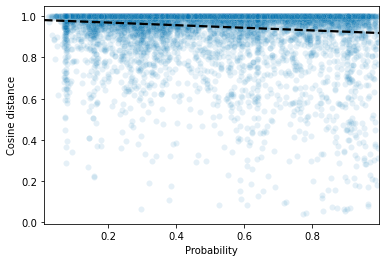

In [57]:
a = sns.regplot(data=final_df, 
                x='proba', 
                y='cosine_dist',
                line_kws = {
                    'color': 'k', 
                    'linestyle' : '--',
                           },
                scatter=False
           )
a = sns.scatterplot(data=final_df.sample(10000), 
                    x='proba', 
                    y='cosine_dist', 
                    alpha=0.1,
                   )
plt.ylabel("Cosine distance")
plt.xlabel("Probability")


In [43]:
final_df.sample()

interaction label     proba  cosine_dist  bin
656073  VOG0933-VOG4555     1  0.557761     0.746708  0.5

In [59]:
save_it(a.get_figure(), figures_dir, 9, dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [49]:
npreds= final_df.shape[0]
proba_array = np.array(final_df['proba'], dtype=np.float64)
cosine_dist_array = np.array(final_df['cosine_dist'], dtype=np.float64)
reg = linregress(proba_array, cosine_dist_array)
print(f"Predictions number: {npreds}")
print(f"R: {round(reg.rvalue,3)}")
print(f"Pval: {reg.pvalue}")

Predictions number: 146456
R: -0.141
Pval: 0.0
